# 手写数字识别

In [2]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

In [3]:
# 设置超参数
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 10

In [4]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [5]:
# 获取数据集
train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集


In [6]:
# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c:\Users\halo\.conda\envs\py38\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\halo\.conda\envs\py38\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


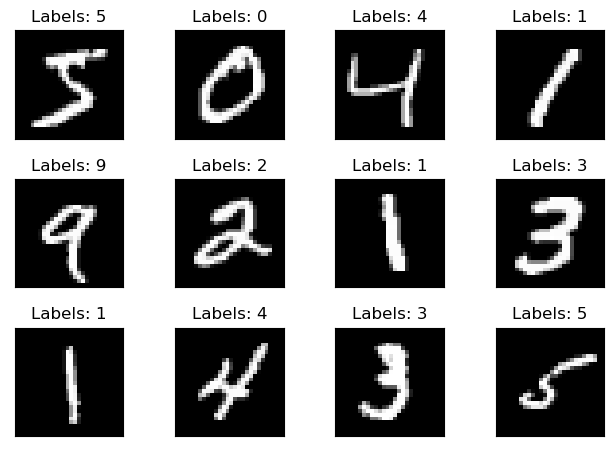

In [7]:
# 展示数据集
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

In [9]:
criterion = nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量

In [14]:
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    # 创建一个字典来保存梯度
    gradients = {}
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        # 保存梯度
        gradients = {name: param.grad.clone() for name, param in model.named_parameters() if param.grad is not None}
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零
            # 将每个梯度保存到字典中
            for name, parameter in model.named_parameters():
                if parameter.grad is not None:
                    # .clone()确保我们有梯度的复制，而非引用
                    gradients[name] = parameter.grad.clone()
        torch.save(model.state_dict(), './model.pt')
        torch.save(gradients, './model_gradients.pt')

In [15]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc

[1,   300]: loss: 0.033 , acc: 99.02 %
[1,   600]: loss: 0.032 , acc: 98.98 %
[1,   900]: loss: 0.028 , acc: 99.05 %
[1 / 10]: Accuracy on test set: 98.8 % 
[2,   300]: loss: 0.029 , acc: 99.10 %
[2,   600]: loss: 0.028 , acc: 99.12 %
[2,   900]: loss: 0.030 , acc: 99.03 %
[2 / 10]: Accuracy on test set: 98.9 % 
[3,   300]: loss: 0.025 , acc: 99.22 %
[3,   600]: loss: 0.028 , acc: 99.13 %
[3,   900]: loss: 0.027 , acc: 99.18 %
[3 / 10]: Accuracy on test set: 98.9 % 
[4,   300]: loss: 0.022 , acc: 99.33 %
[4,   600]: loss: 0.025 , acc: 99.24 %
[4,   900]: loss: 0.028 , acc: 99.08 %
[4 / 10]: Accuracy on test set: 98.7 % 
[5,   300]: loss: 0.020 , acc: 99.40 %
[5,   600]: loss: 0.024 , acc: 99.24 %
[5,   900]: loss: 0.025 , acc: 99.22 %
[5 / 10]: Accuracy on test set: 98.9 % 
[6,   300]: loss: 0.019 , acc: 99.37 %
[6,   600]: loss: 0.022 , acc: 99.32 %
[6,   900]: loss: 0.021 , acc: 99.34 %
[6 / 10]: Accuracy on test set: 99.0 % 
[7,   300]: loss: 0.018 , acc: 99.47 %
[7,   600]: loss: 0

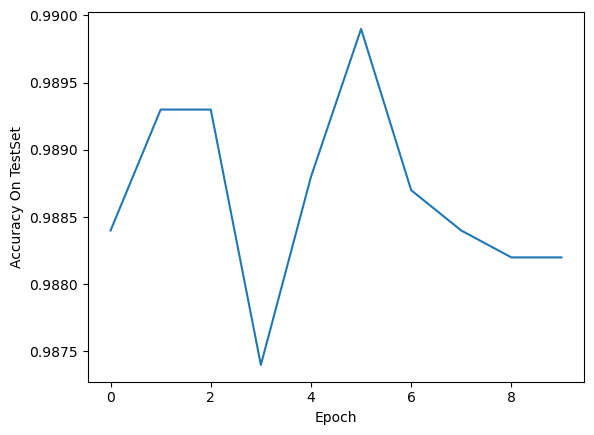

In [16]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch)
        acc_test = test()
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()